In [13]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from mogtrain import MoGTrainer

from tqdm import tqdm_notebook as tqdm

import delfi.distribution as dd

from delfi.utils.viz import probs2contours

from parameters import ParameterSet
import pickle

%matplotlib inline

In [14]:
params = pickle.load(open('example_mog.pkl', 'rb'))

In [15]:
def print_pdf(pdf, name):
    po = np.get_printoptions()
    np.set_printoptions(precision=2)
    print("{}:".format(name))
    print("----------------")
    print("Mixture weights: {}".format(pdf.a))
    print("Means:")
    for x in pdf.xs:
        print("{}".format(x.m))
    print()
    print("Covariances:")
    for x in pdf.xs:
        print("{}".format(x.S))
    print()
    np.set_printoptions(**po)

In [16]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=log) / self.b.eval(samples, log=log)
        return ret / self.Z
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

In [19]:
trainer = MoGTrainer(params.prop, params.prior, params.uncorrected, ncomponents=params.n_comps, nsamples=10000, lr=0.01, es_thresh=0, es_rounds=1000)

losses = trainer.train(nsteps=-1)

pred = trainer.get_mog()

loss=[ 3.67100763]: : 1428it [00:23, 60.36it/s]


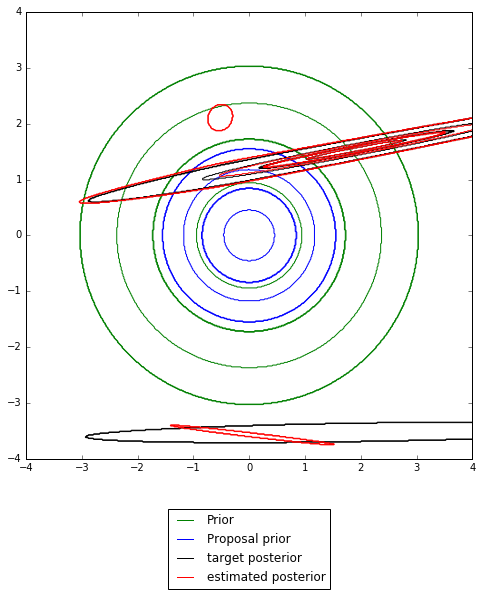

Target posterior:
----------------
Mixture weights: [ 0.11  0.54  0.29  0.03  0.03]
Means:
[ 2.12 -3.53]
[ 1.93  1.54]
[-0.25  2.59]
[-3.03  2.26]
[-1.02 -1.06]

Covariances:
[[ 9.39  0.15]
 [ 0.15  0.01]]
[[ 2.63  0.5 ]
 [ 0.5   0.1 ]]
[[ 3.4   1.18]
 [ 1.18  6.11]]
[[ 8.73 -2.92]
 [-2.92  2.19]]
[[  4.96  -3.27]
 [ -3.27  12.94]]

Estimated posterior:
----------------
Mixture weights: [ 0.01  0.65  0.25  0.07  0.03]
Means:
[ 0.09 -3.58]
[ 1.9   1.54]
[-0.68  1.79]
[-0.13  2.71]
[-1.18 -2.13]

Covariances:
[[ 0.8  -0.09]
 [-0.09  0.01]]
[[ 2.6  0.5]
 [ 0.5  0.1]]
[[ 3.55  0.25]
 [ 0.25  4.16]]
[[ 2.84  0.15]
 [ 0.15  2.45]]
[[ 2.88 -0.26]
 [-0.26  6.64]]



In [21]:
res = 500
xlims = (-params.x_width, params.x_width)
ylims = xlims

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
x, y = np.meshgrid(xaxis, yaxis)

xy = np.concatenate([x.reshape([-1, 1]), 
                     y.reshape([-1, 1])], 
                    axis=1)

levels = [0.7, 0.5, 0.3, 0.1]

prior_contour = probs2contours(params.prior.eval(xy, log=False), levels).reshape(res, res)
prop_contour = probs2contours(params.prop.eval(xy, log=False), levels).reshape(res, res)
target_contour = probs2contours(params.target.eval(xy, log=False), levels).reshape(res, res)
pred_contour = probs2contours(pred.eval(xy, log=False), levels).reshape(res, res)

plt.figure(figsize=(8, 8))

plt.contour(x, y, prior_contour, colors=('g'))
plt.contour(x, y, prop_contour, colors=('b'))
plt.contour(x, y, target_contour, colors=('k'))
plt.contour(x, y, pred_contour, colors=('r'))

green_line = mlines.Line2D([], [], color='g', label='Prior')
blue_line = mlines.Line2D([], [], color='b', label='Proposal prior')
black_line = mlines.Line2D([], [], color='k', label='target posterior')
red_line = mlines.Line2D([], [], color='r', label='estimated posterior')
plt.legend(handles=[green_line, blue_line, black_line, red_line], 
           loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()

print_pdf(params.target, "Target posterior")
print_pdf(pred, "Estimated posterior")